In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## EDA

In [3]:
# Load Data
train_path = '/kaggle/input/titanic/train.csv'
test_path = '/kaggle/input/titanic/test.csv'
sub_path = '/kaggle/input/titanic/gender_submission.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_sub = pd.read_csv(sub_path)

print(df_train.isnull().sum())
print("======================")
print(df_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [4]:
# 'Age', 'Cabin', 'Embarked', 'Fare' colums has NaN
# In 'Age','Fare' NaN is mean for Pclass
# In 'Cabin', 'Embarked', NaN is 'N'

# Mean for Pclass
print(df_train.groupby('Pclass')[['Age', 'Fare']].mean())

# 'Cabin' preprocessing
def simplify_cabin(cabin):
    if isinstance(cabin, str) and cabin.strip().isalnum() and len(cabin) > 1:
        if cabin[0].isalpha() and cabin[1:].isdigit():
            return cabin[0]
    return np.nan

df_train['Cabin'] = df_train['Cabin'].apply(simplify_cabin)
df_test['Cabin'] = df_test['Cabin'].apply(simplify_cabin)

# Fill NaN Function
def fill_NaN(df):
    df['Age'] = df['Age'].fillna(df.groupby('Pclass')['Age'].transform('mean'))
    df['Fare'] = df['Fare'].fillna(df.groupby('Pclass')['Fare'].transform('mean'))
    df['Cabin'] = df['Cabin'].fillna('N')
    df['Embarked'] = df['Embarked'].fillna('N')
    return df

df_train = fill_NaN(df_train)
df_test = fill_NaN(df_test)

print("======================")
print(f'train isnull : {df_train.isnull().values.any()}')
print(f'test isnull : {df_test.isnull().values.any()}')
print(f'Cabin unique : {df_train["Cabin"].unique()}')
print(f'Embarked unique : {df_train["Embarked"].unique()}')

              Age       Fare
Pclass                      
1       38.233441  84.154687
2       29.877630  20.662183
3       25.140620  13.675550
train isnull : False
test isnull : False
Cabin unique : ['N' 'C' 'E' 'G' 'D' 'A' 'B' 'F']
Embarked unique : ['S' 'C' 'Q' 'N']


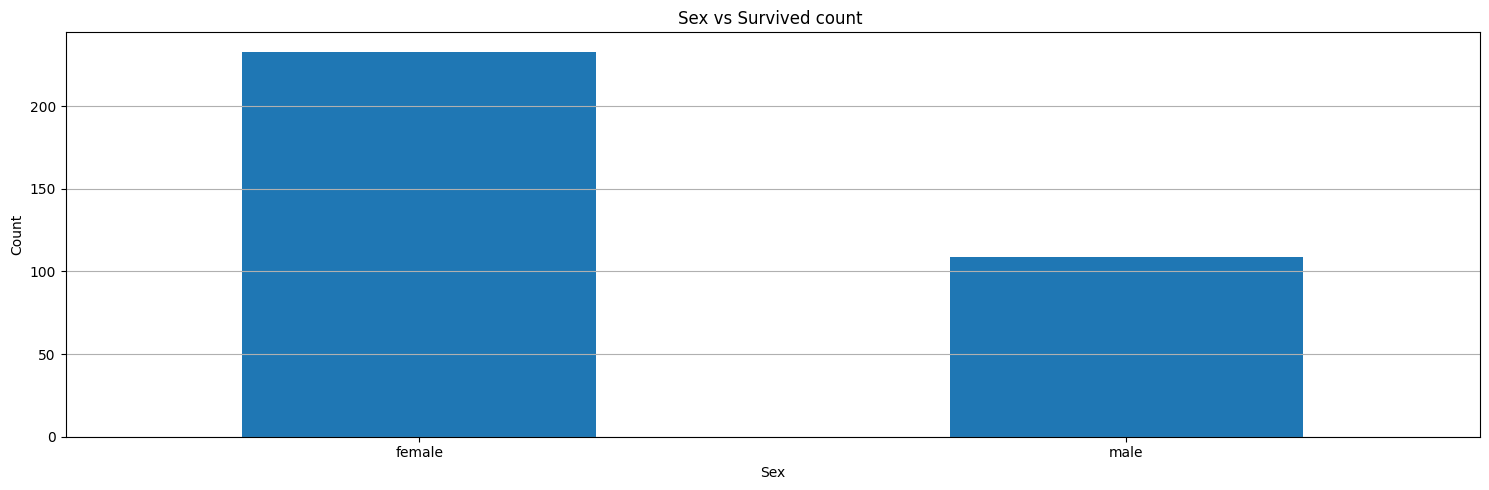

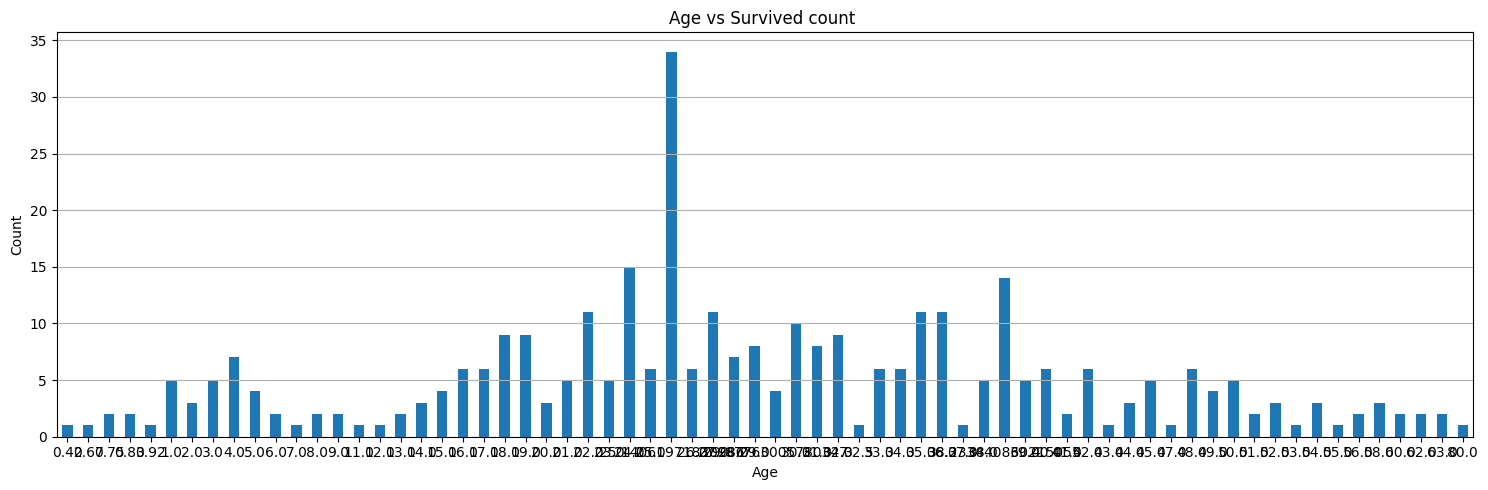

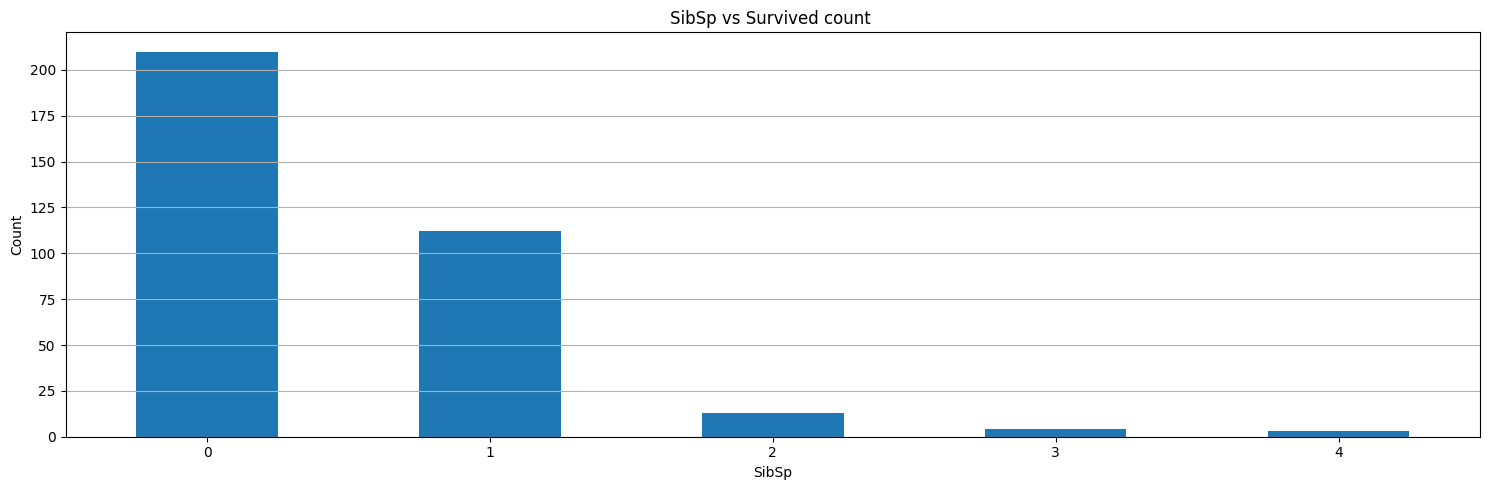

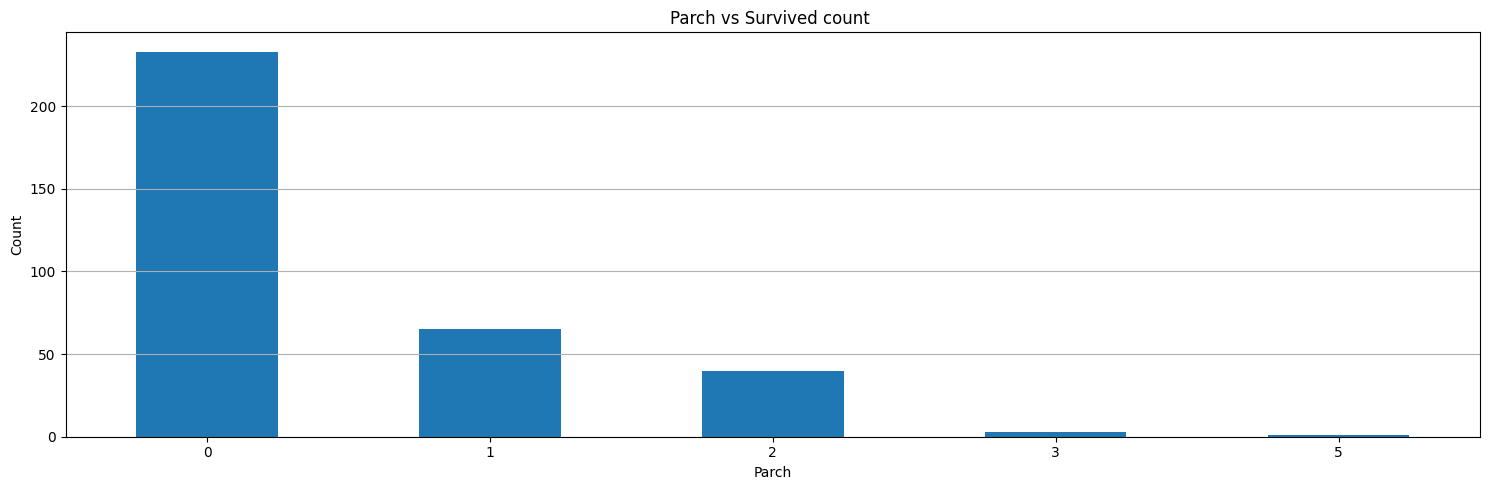

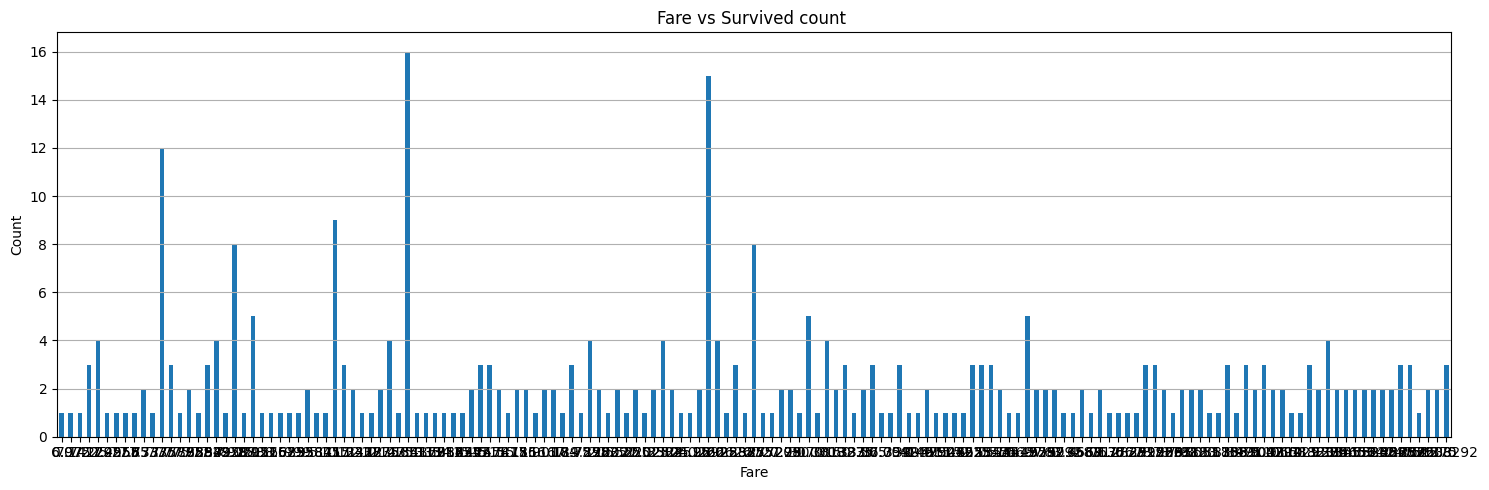

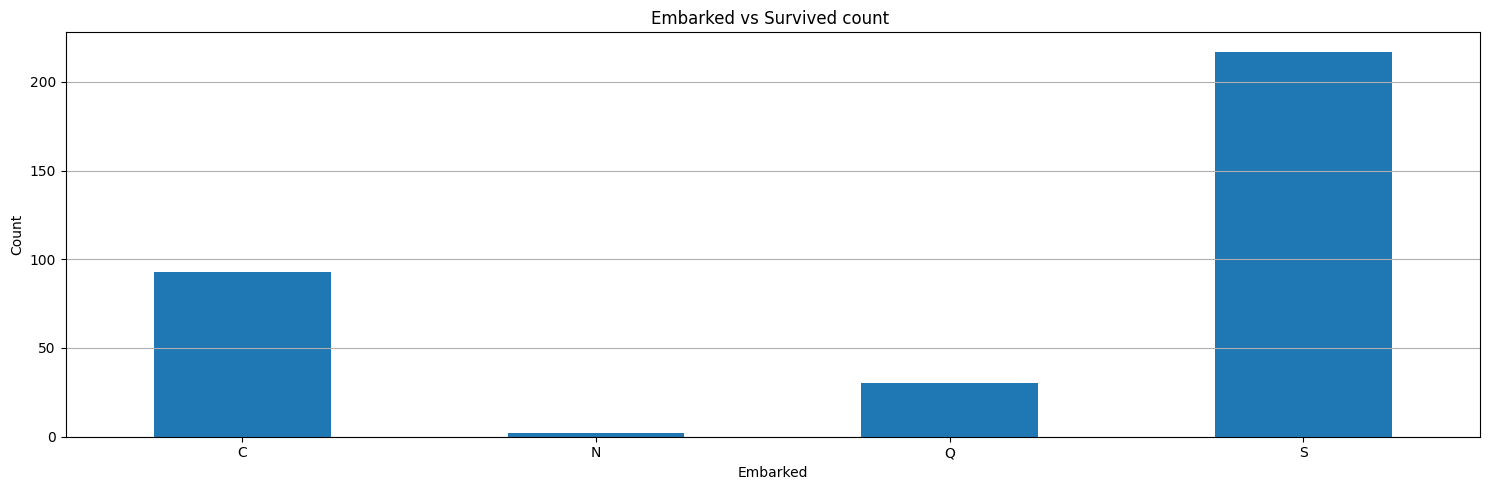

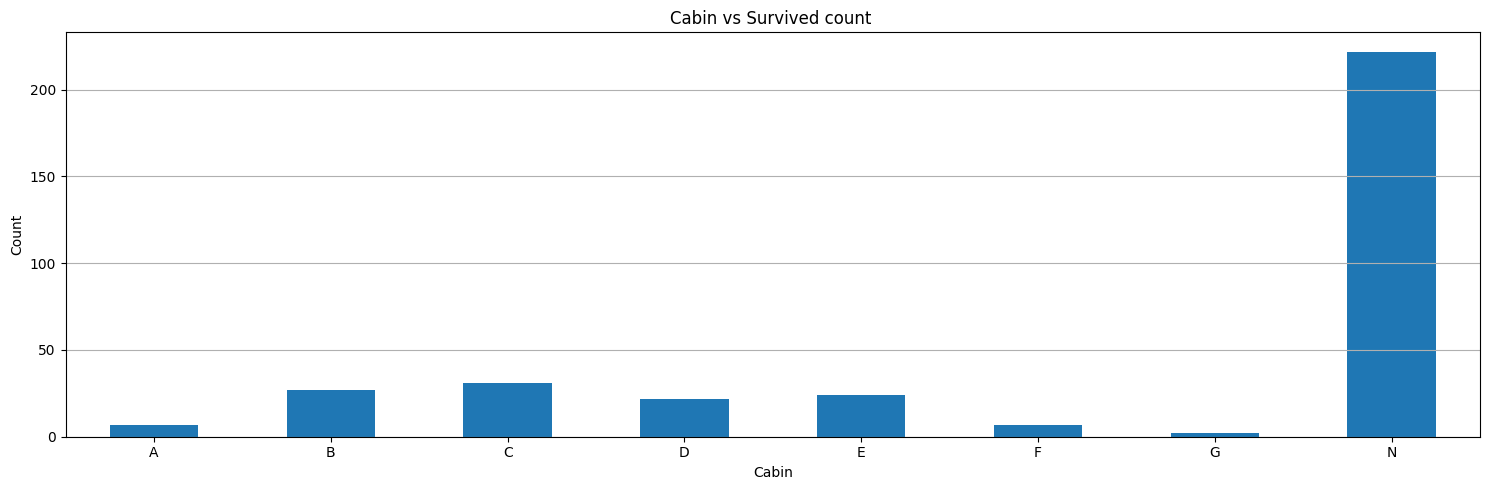

In [5]:
# Check Scatter
target_col = 'Survived'
features = ['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin']

for col in features:
    survived_counts = df_train[df_train['Survived'] == 1][col].value_counts().sort_index()

    plt.figure(figsize=(15, 5))
    survived_counts.plot(kind='bar')
    plt.title(f'{col} vs Survived count ')
    plt.ylabel('Count')
    plt.xlabel(col)
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

## Preprocessing
If use Tree Moel, Label or Ordinal encoding<br>
If use Linear Model, One-hot encoding

In [6]:
# In this case, will use Label Encoding
# And, 'Age', 'Fare', 'SibSp', 'Parch' will be normalized
from sklearn.preprocessing import LabelEncoder, StandardScaler

encoder = LabelEncoder()

def data_encoding(df):
    df['Sex'] = encoder.fit_transform(df['Sex'])
    df['Cabin'] = encoder.fit_transform(df['Cabin'])
    df['Embarked'] = encoder.fit_transform(df['Embarked'])
    return df

df_train = data_encoding(df_train)
df_test = data_encoding(df_test)

scaler = StandardScaler()
df_train[['Age', 'Fare', 'SibSp', 'Parch']] = scaler.fit_transform(df_train[['Age', 'Fare', 'SibSp', 'Parch']])
df_test[['Age', 'Fare', 'SibSp', 'Parch']] = scaler.transform(df_test[['Age', 'Fare', 'SibSp', 'Parch']])


# Select Feature
df_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']].head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,-0.552360,0.432793,-0.473674,-0.502445,7,3
1,1,0,0.659475,0.432793,-0.473674,0.786845,2,0
2,3,0,-0.249401,-0.474545,-0.473674,-0.488854,7,3
3,1,0,0.432256,0.432793,-0.473674,0.420730,2,3
4,3,1,0.432256,-0.474545,-0.473674,-0.486337,7,3
5,3,1,-0.314491,-0.474545,-0.473674,-0.478116,7,2
6,1,1,1.871311,-0.474545,-0.473674,0.395814,4,3
7,3,1,-2.067155,2.247470,0.767630,-0.224083,7,3
8,3,0,-0.173662,-0.474545,2.008933,-0.424256,7,3
9,2,0,-1.158278,0.432793,-0.473674,-0.042956,7,0


## Model train

In [7]:
# Split input and target data
X = df_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']].to_numpy()
y = df_train['Survived'].to_numpy()

X_pred = df_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']].to_numpy()

#### 1. Logistic Regression

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings 

warnings.filterwarnings('ignore')
lr = LogisticRegression()

hp = {
    'penalty' : ['l1', 'l2'],
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'solver' : ['lbfgs', 'liblinear'],
    'max_iter' : [100, 1000, 10000]
}

gs = GridSearchCV(lr, param_grid=hp, cv=5)
gs.fit(X_train, y_train)
lr = gs.best_estimator_
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))


0.8103932584269663
0.7877094972067039


#### 2. SGDClassifier

In [10]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

hp = {
    'max_iter' : [10, 100, 1000, 10000]
}

sc = SGDClassifier(loss='log_loss')
gs = GridSearchCV(sc, param_grid=hp, cv=5)
gs.fit(X_train, y_train)
sc = gs.best_estimator_

print(sc.score(X_train, y_train))
print(sc.score(X_test, y_test))

0.7205056179775281
0.7262569832402235


#### 3. Decsion Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier()
hp = {
    'min_impurity_decrease' : np.arange(0.0001, 0.001, 0.0001),
    'max_depth' : range(5, 20, 1),
    'min_samples_split' : range(2, 100, 10)
}

gs = GridSearchCV(dt, hp)
gs.fit(X_train, y_train)
dt = gs.best_estimator_

print(gs.best_params_)
print(dt.score(X_train, y_train))
print(dt.score(X_test, y_test))


{'max_depth': 5, 'min_impurity_decrease': 0.0001, 'min_samples_split': 12}
0.8581460674157303
0.8156424581005587


#### 4. Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(oob_score=True)
rf.fit(X_train, y_train)

print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))
print(rf.oob_score_)

0.9873595505617978
0.8268156424581006
0.7991573033707865


#### 5. Extra Tree

In [13]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_validate

et = ExtraTreesClassifier()
scores = cross_validate(et, X_train, y_train, return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9894644343723986 0.7823007977937555


#### 6. Gradient Boosting

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
scores = cross_validate(gb, X_train, y_train, return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9090586748065241 0.8229981286319316


In [15]:
from sklearn.model_selection import GridSearchCV
hp = {
    'n_estimators': np.arange(10, 500, 10),
    'learning_rate': np.linspace(0.1, 0.5, 5)
}
gs = GridSearchCV(gb, hp, n_jobs=-1)
gs.fit(X_train, y_train)
gb = gs.best_estimator_
print(gb.score(X_train, y_train))
print(gb.score(X_test, y_test))

0.9157303370786517
0.8435754189944135


## Submission

In [16]:
final_model = gb
y_pred = final_model.predict(X_pred)

df_sub['Survived'] = y_pred

df_sub.to_csv('/kaggle/working/submission.csv', index=False)